In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install chart-studio

In [ ]:
!pip install plotly

In [ ]:
from plotly import tools
import chart_studio.plotly as py  # Modified import statement
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [ ]:
df = pd.read_csv('bank.csv')
term_deposits = df.copy()

## **DATA UNDERSTANDING**

In [ ]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [ ]:
df.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

## **DATA PREPARATION**

In [ ]:
#Check missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


There are no missing values

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

fig = plt.figure(figsize=(12, 8))

df['deposit'] = LabelEncoder().fit_transform(df['deposit'])

numeric_df = df.select_dtypes(exclude="object")

<Figure size 1200x800 with 0 Axes>

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
# Split the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(term_deposits, term_deposits["loan"]):
    stratified_train = term_deposits.loc[train_set]
    stratified_test = term_deposits.loc[test_set]

stratified_train["loan"].value_counts()/len(df)
stratified_test["loan"].value_counts()/len(df)

loan
no     0.173894
yes    0.026160
Name: count, dtype: float64

In [ ]:
# Separate the labels and the features.
train_data = stratified_train
test_data = stratified_test
train_data.shape
test_data.shape
train_data['deposit'].value_counts()

deposit
no     4697
yes    4232
Name: count, dtype: int64

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, encoding='onehot', categories='auto', dtype=float,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=int)
        X_mask = np.ones_like(X, dtype=bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8929 entries, 9867 to 9672
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        8929 non-null   int64 
 1   job        8929 non-null   object
 2   marital    8929 non-null   object
 3   education  8929 non-null   object
 4   default    8929 non-null   object
 5   balance    8929 non-null   int64 
 6   housing    8929 non-null   object
 7   loan       8929 non-null   object
 8   contact    8929 non-null   object
 9   day        8929 non-null   int64 
 10  month      8929 non-null   object
 11  duration   8929 non-null   int64 
 12  campaign   8929 non-null   int64 
 13  pdays      8929 non-null   int64 
 14  previous   8929 non-null   int64 
 15  poutcome   8929 non-null   object
 16  deposit    8929 non-null   object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign", "pdays", "previous","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month",
                                     "poutcome"])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [ ]:
y_train = train_data['deposit']
y_test = test_data['deposit']
y_train.shape

(8929,)

In [ ]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)
y_train_yes = (y_train == 1)
y_train
y_train_yes

array([False, False,  True, ...,  True,  True, False])

In [ ]:
some_instance = X_train[1250]

# **DATA VISUALIZATION**

In [ ]:
# Define my desired color palette
my_palette = sns.color_palette("Set2")

# Set the color palette
sns.set_palette(my_palette)

<ipython-input-106-7c8831bb79f4>:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



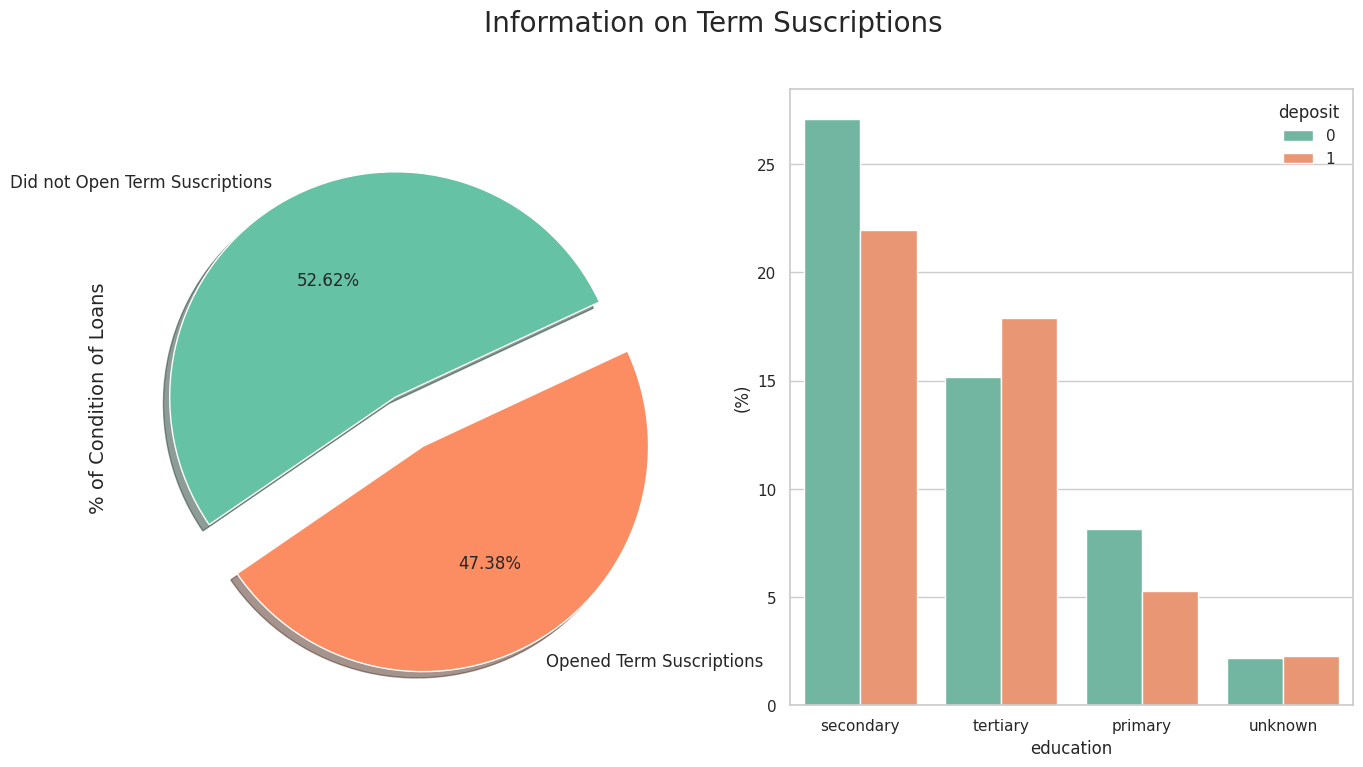

In [ ]:
f, ax = plt.subplots(1,2, figsize=(16,8))

labels ="Did not Open Term Suscriptions", "Opened Term Suscriptions"

plt.suptitle('Information on Term Suscriptions', fontsize=20)

df["deposit"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True,
                                             labels=labels, fontsize=12, startangle=25)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

sns.barplot(x="education", y="balance", hue="deposit", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")
ax[1].set_xticklabels(df["education"].unique(), rotation=0, rotation_mode="anchor")
plt.show()

<ipython-input-107-57c840cbf0cd>:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



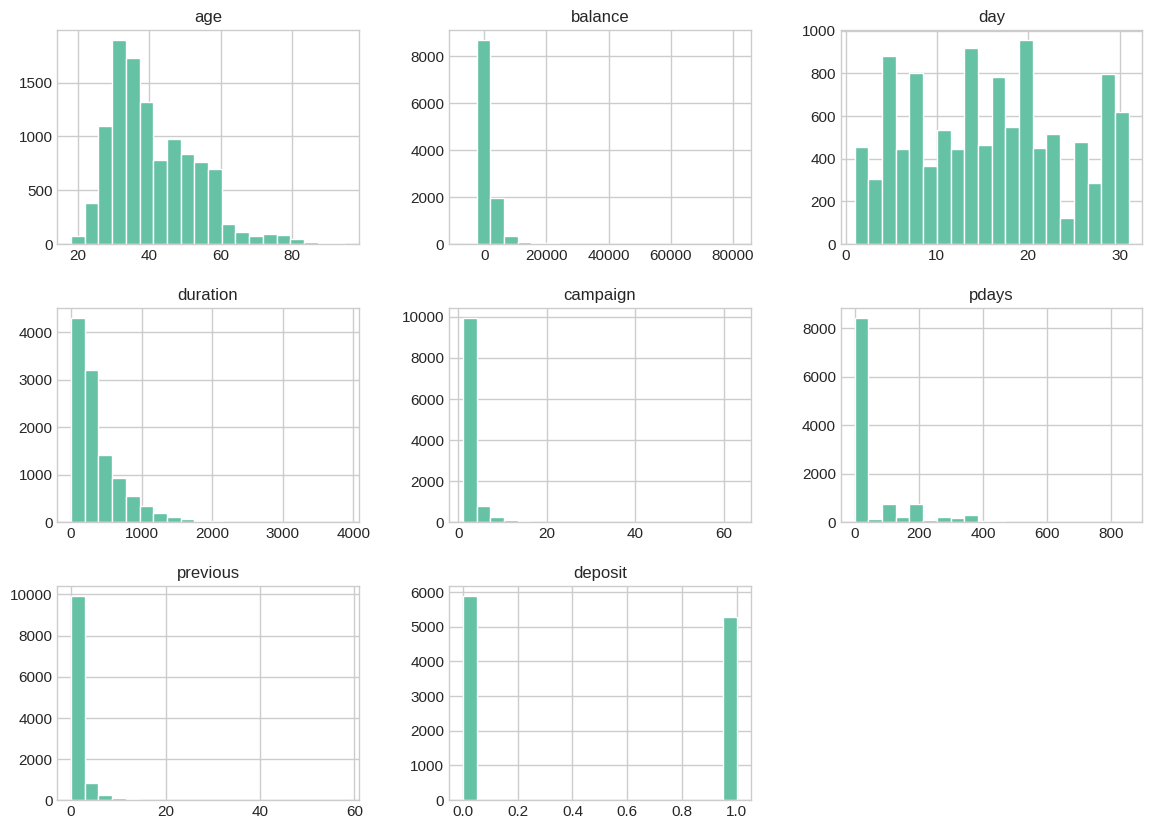

In [ ]:
# Let's see how the numeric data is distributed.
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(14,10))
plt.show()

In [ ]:
df['deposit'].value_counts()

deposit
0    5873
1    5289
Name: count, dtype: int64

<ipython-input-109-b0d6833abe9b>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



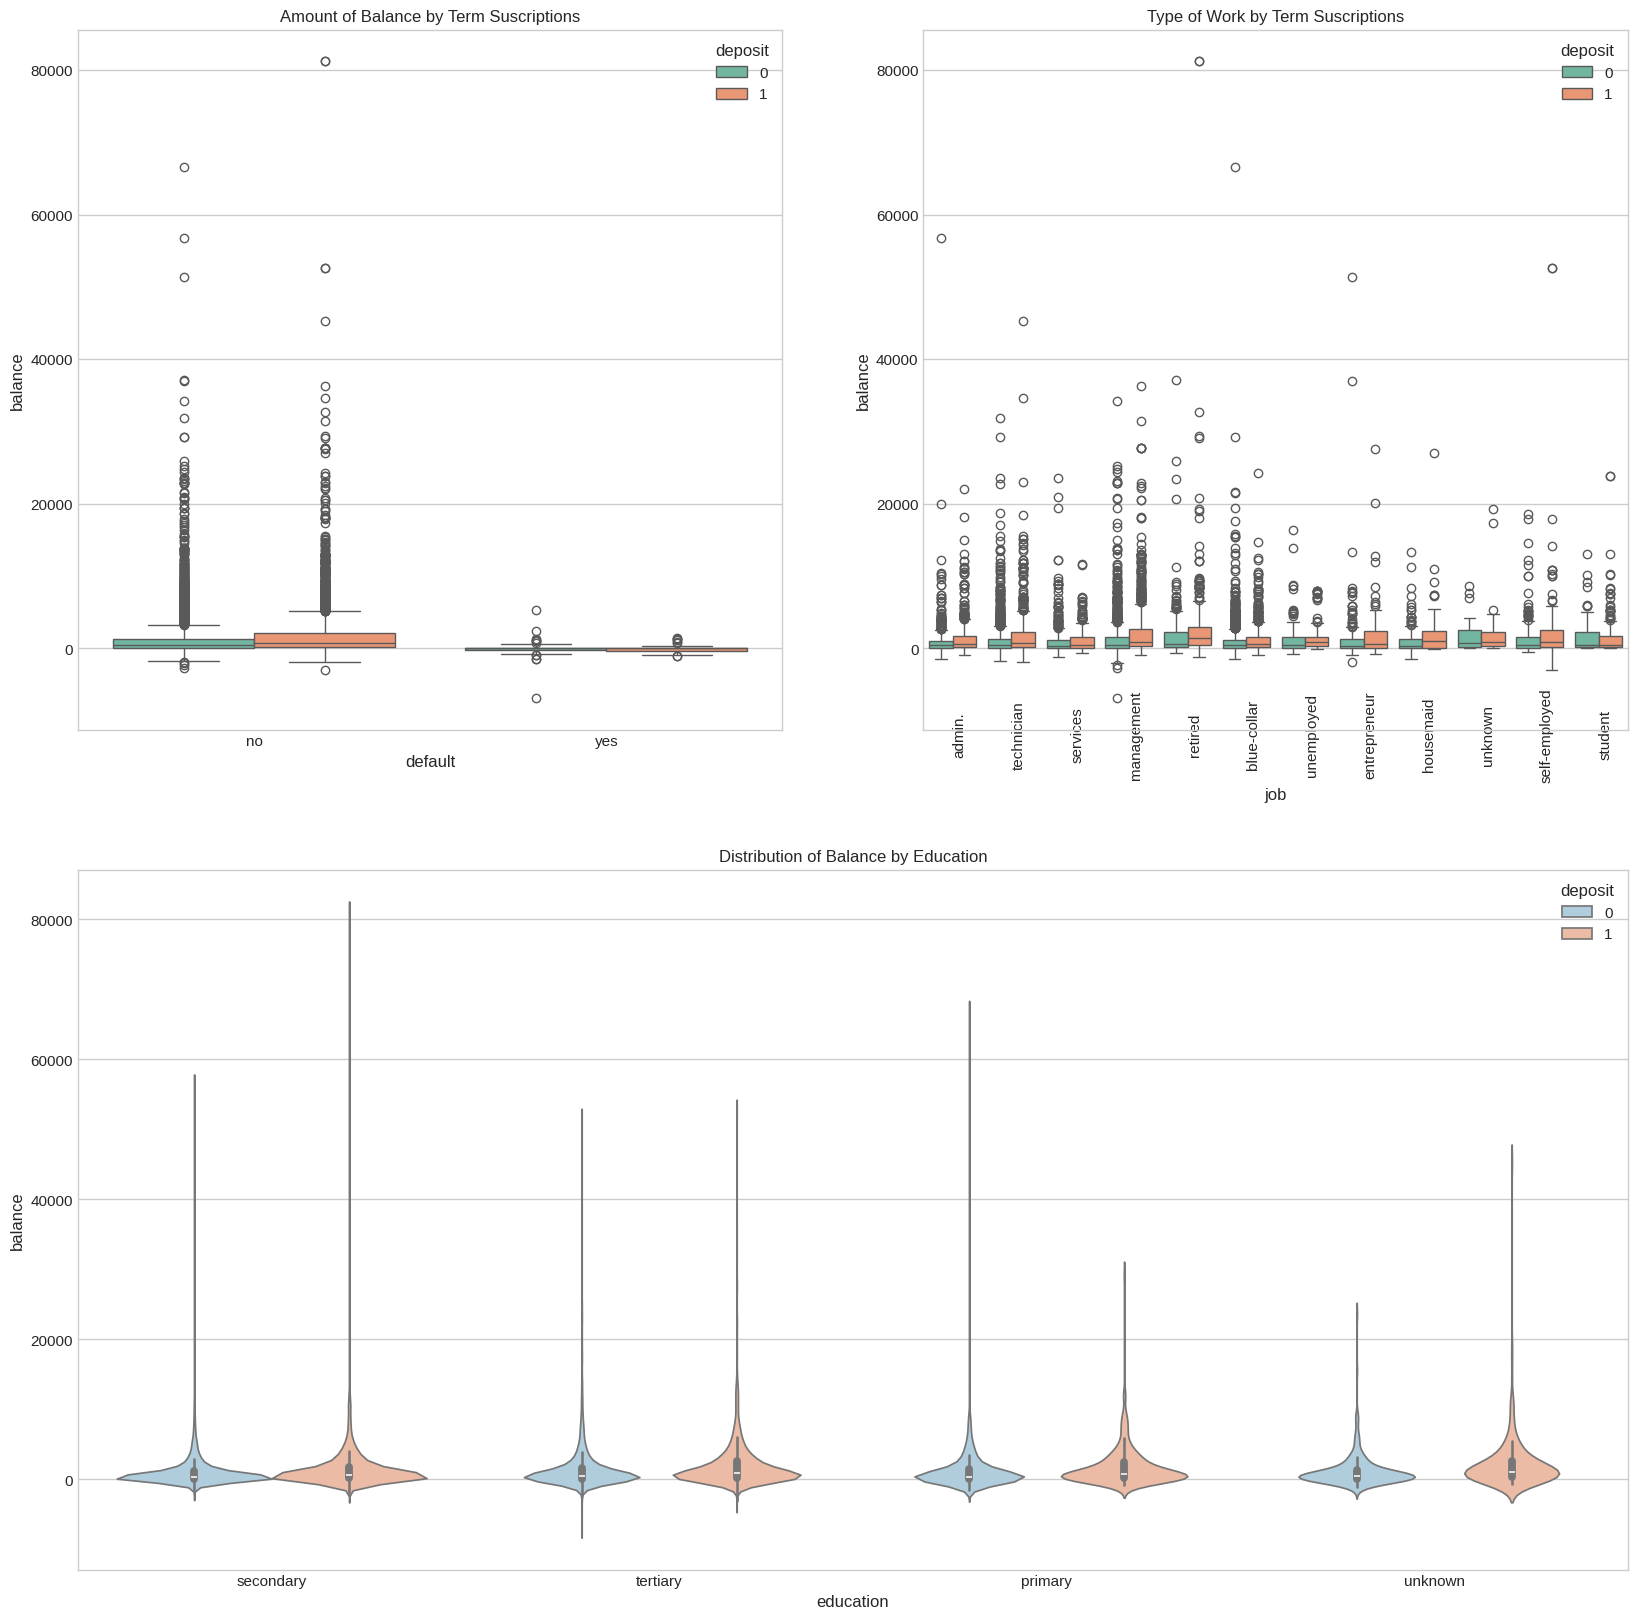

In [ ]:
# plt.style.use('dark_background')
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

g = sns.boxplot(x="default", y="balance", hue="deposit",
                    data=df, ax=ax1)

g.set_title("Amount of Balance by Term Suscriptions")

# ax.set_xticklabels(df["default"].unique(), rotation=45, rotation_mode="anchor")

g1 = sns.boxplot(x="job", y="balance", hue="deposit",
                 data=df, ax=ax2)

g1.set_xticklabels(df["job"].unique(), rotation=90, rotation_mode="anchor")
g1.set_title("Type of Work by Term Suscriptions")

g2 = sns.violinplot(data=df, x="education", y="balance", hue="deposit", palette="RdBu_r")

g2.set_title("Distribution of Balance by Education")


plt.show()

**Mean Age** is aproximately **41** years old. (Minimum: 18 years old and Maximum: 95 years old.)

The **mean balance** is 1,528. However, the Standard Deviation (std) is a high number so we can understand through this that the balance is heavily distributed across the dataset.

The dataset suggests dropping the 'duration' column from the analysis. This decision is based on the understanding that 'duration' is highly correlated with a client's decision to subscribe to a term deposit. Since 'duration' represents the amount of time spent on calls with potential clients, excluding it from the analysis is logical. Clients without calls would have a zero duration, rendering this feature less relevant. Additionally, a longer duration tends to correlate with higher interest and commitment from potential clients, thus influencing their likelihood of subscribing to a term deposit.

# Analysis by Occupation

In [ ]:
# Drop the Job Occupations that are "Unknown"
df = df.drop(df.loc[df["job"] == "unknown"].index)

# Admin and management are basically the same let's put it under the same categorical value
lst = [df]

for col in lst:
    col.loc[col["job"] == "admin.", "job"] = "management"

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [ ]:
pip install squarify

In [ ]:
import squarify
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio

In [ ]:
df = df.drop(df.loc[df["balance"] == 0].index)

x = 0
y = 0
width = 100
height = 100

job_names = df['job'].value_counts().index
values = df['job'].value_counts().tolist()

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)

shapes = []
annotations = []

for r, label in zip(rects, job_names):
    shapes.append(
        dict(
            type='rect',
            x0=r['x'],
            y0=r['y'],
            x1=r['x'] + r['dx'],
            y1=r['y'] + r['dy'],
            line=dict(width=2),
        )
    )
    annotations.append(
        dict(
            x=r['x'] + (r['dx'] / 2),
            y=r['y'] + (r['dy'] / 2),
            text=label,
            showarrow=False
        )
    )

# For hover text
trace0 = go.Scatter(
    x=[r['x'] + (r['dx'] / 2) for r in rects],
    y=[r['y'] + (r['dy'] / 2) for r in rects],
    text=[str(v) for v in job_names],
    mode='text',
)

layout = dict(
    title='Number of Occupations <br> <i>(From our Sample Population)</i>',
    height=700,
    width=700,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest'
)

# With hovertext
figure = dict(data=[trace0], layout=layout)

# Save the plot as an HTML file
plot(figure, filename='squarify-treemap.html')

'squarify-treemap.html'

In [ ]:
from IPython.display import HTML
# Display the HTML file in Colab
HTML(filename='squarify-treemap.html')

In [ ]:
subscribed_df = df[df["deposit"] == "yes"]
occupations = subscribed_df["job"].unique()

traces = []

for occupation in occupations:
    ages = subscribed_df["age"].loc[subscribed_df["job"] == occupation]
    trace = go.Box(
        y=ages,
        name=occupation,
        boxpoints='all',
        jitter=0.5,
        whiskerwidth=0.2,
        marker=dict(
            size=2,
        ),
        line=dict(width=1),
    )
    traces.append(trace)

layout = go.Layout(
    title='Distribution of Ages by Occupation',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(224,255,246)',
    plot_bgcolor='rgb(251,251,251)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

**Number of Occupations**: Management is the occupation that is more prevalent in this dataset.
**Age by Occupation**: As expected, the retired are the ones who have the highest median age while student are the lowest.

# Analysis by Marital Status

In [ ]:
df['marital'].value_counts()

marital
married     5815
single      3336
divorced    1174
Name: count, dtype: int64

In [ ]:
df['marital'].unique()

array(['married', 'divorced', 'single'], dtype=object)

In [ ]:
df['marital'].value_counts().tolist()

[5815, 3336, 1174]

In [ ]:
vals = df['marital'].value_counts().tolist()
labels = ['married', 'divorced', 'single']

data = [go.Bar(
            x=labels,
            y=vals,
    marker=dict(
    color="#FE9A2E")
    )]

layout = go.Layout(
    title="Count by Marital Status",
)

fig = go.Figure(data=data, layout=layout)

plot(figure, filename='basic-bar.html')
HTML(filename='basic-bar.html')

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [ ]:
fig = ff.create_facet_grid(
    df,
    x='duration',
    y='balance',
    color_name='marital',
    show_boxes=False,
    marker={'size': 10, 'opacity': 1.0},
    colormap={'single': 'rgb(165, 242, 242)', 'married': 'rgb(253, 174, 216)', 'divorced': 'rgba(201, 109, 59, 0.82)'}
)

plot(fig, filename='facet - custom colormap.html')
HTML(filename='facet - custom colormap.html')

I observed that divorced individuals tend to have lower financial balances, likely due to asset division during divorce proceedings

# Marital Status and Education

In [ ]:
df = df.drop(df.loc[df["education"] == "unknown"].index)
df['education'].unique()

array(['secondary', 'tertiary', 'primary'], dtype=object)

In [ ]:
df['marital/education'] = np.nan
lst = [df]

for col in lst:
    col.loc[(col['marital'] == 'single') & (df['education'] == 'primary'), 'marital/education'] = 'single/primary'
    col.loc[(col['marital'] == 'married') & (df['education'] == 'primary'), 'marital/education'] = 'married/primary'
    col.loc[(col['marital'] == 'divorced') & (df['education'] == 'primary'), 'marital/education'] = 'divorced/primary'
    col.loc[(col['marital'] == 'single') & (df['education'] == 'secondary'), 'marital/education'] = 'single/secondary'
    col.loc[(col['marital'] == 'married') & (df['education'] == 'secondary'), 'marital/education'] = 'married/secondary'
    col.loc[(col['marital'] == 'divorced') & (df['education'] == 'secondary'), 'marital/education'] = 'divorced/secondary'
    col.loc[(col['marital'] == 'single') & (df['education'] == 'tertiary'), 'marital/education'] = 'single/tertiary'
    col.loc[(col['marital'] == 'married') & (df['education'] == 'tertiary'), 'marital/education'] = 'married/tertiary'
    col.loc[(col['marital'] == 'divorced') & (df['education'] == 'tertiary'), 'marital/education'] = 'divorced/tertiary'


df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59  management  married  secondary      no     2343     yes   no  unknown   
1   56  management  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54  management  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome  deposit  \
0    5   may      1042         1     -1         0  unknown        1   
1    5   may      1467         1     -1         0  unknown        1   
2    5   may      1389         1     -1         0  unknown        1   
3    5   may       579         1     -1         0  unknown        1   
4    5   may       673         2     -1         0  unknown        1   

   marital/education  
0  married/secondary  
1  married/secondary  
2  married/secondary  
3  married/secondary  
4   married/tertiary

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seab

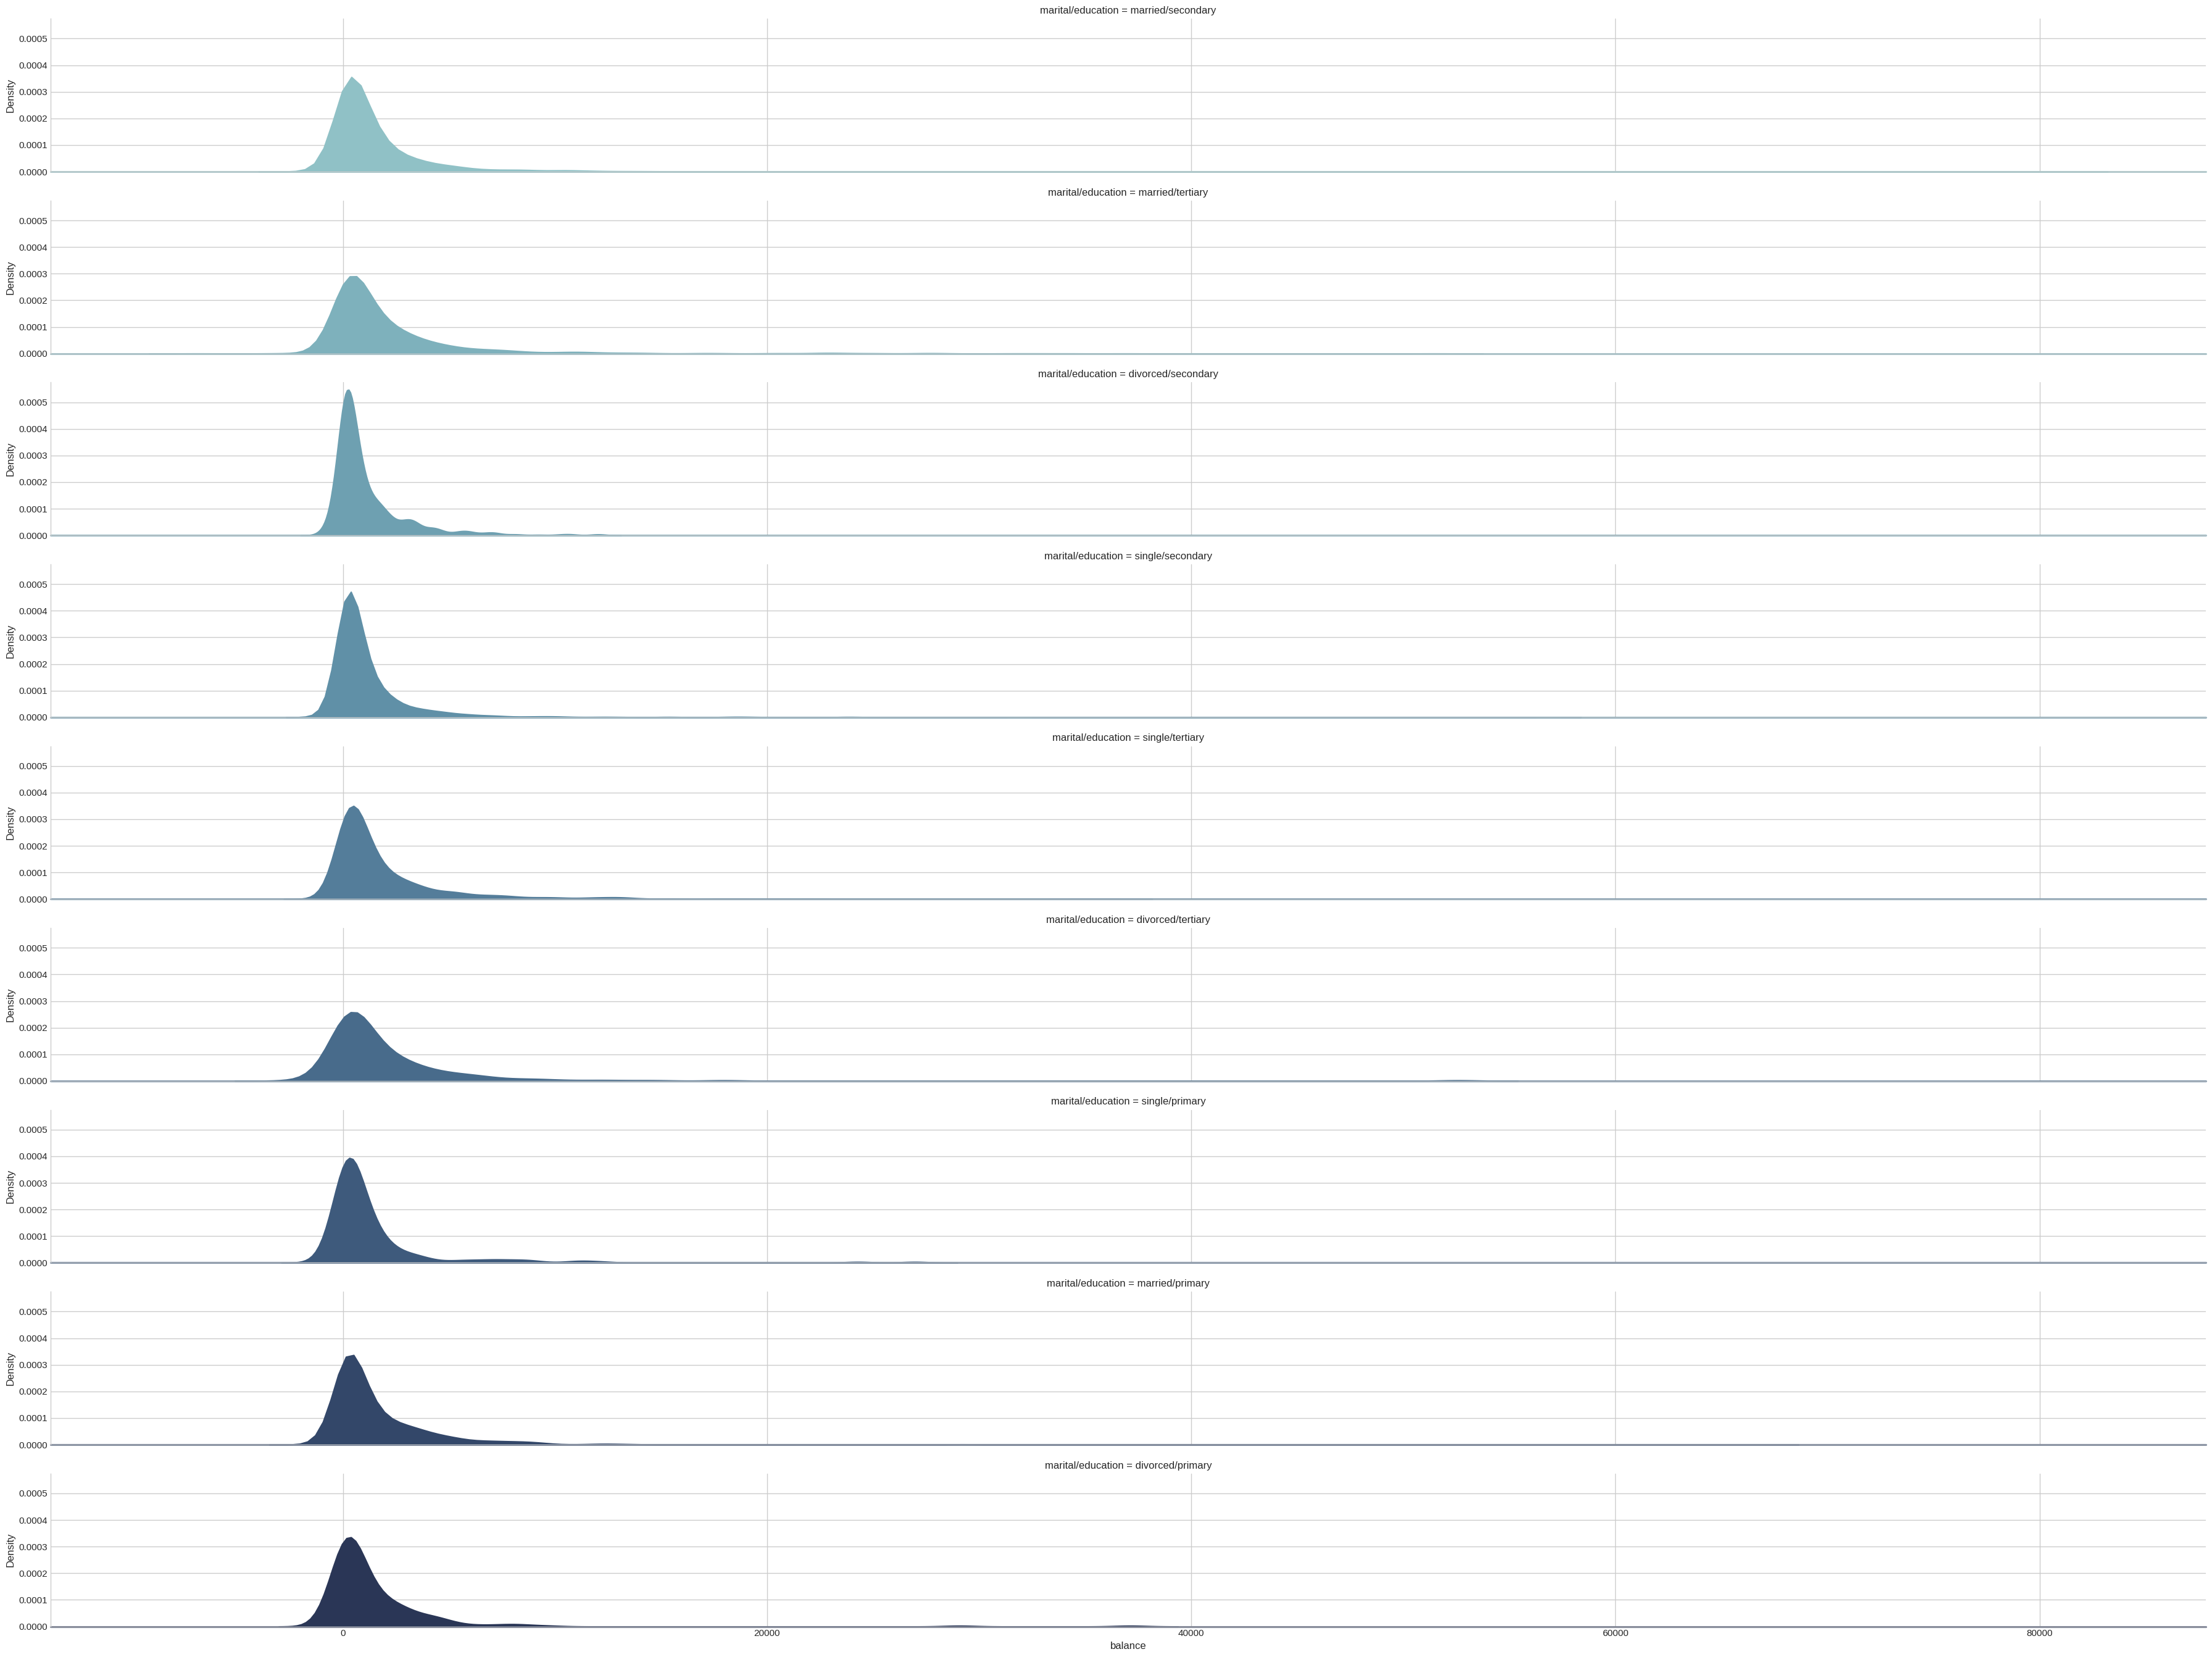

In [ ]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="marital/education", hue="marital/education", aspect=12, palette=pal)

g.map(sns.kdeplot, "balance", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "balance", clip_on=False, color="w", lw=1, bw=0)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

<ipython-input-126-e808ea8200ae>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 1.0, 'Median Balance by Educational/Marital Group')

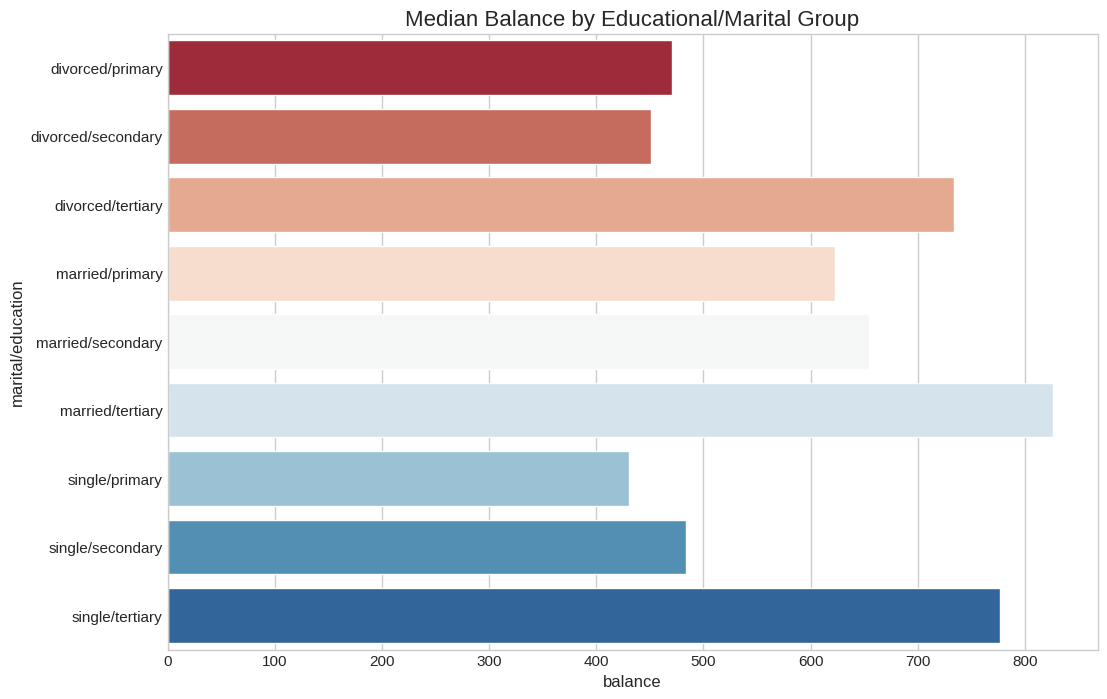

In [ ]:
education_groups = df.groupby(['marital/education'], as_index=False)['balance'].median()

fig = plt.figure(figsize=(12,8))




sns.barplot(x="balance", y="marital/education", data=education_groups,
            label="Total", palette="RdBu")

plt.title('Median Balance by Educational/Marital Group', fontsize=16)

In [ ]:
loan_balance = df.groupby(['marital/education', 'loan'], as_index=False)['balance'].median()

no_loan = loan_balance.loc[loan_balance['loan'] == 'no', 'balance'].values
has_loan = loan_balance.loc[loan_balance['loan'] == 'yes', 'balance'].values

labels = loan_balance['marital/education'].unique().tolist()

trace0 = go.Scatter(
    x=no_loan,
    y=labels,
    mode='markers',
    name='No Loan',
    marker=dict(
        color='rgb(175,238,238)',
        line=dict(
            color='rgb(0,139,139)',
            width=1,
        ),
        symbol='circle',
        size=16,
    )
)

trace1 = go.Scatter(
    x=has_loan,
    y=labels,
    mode='markers',
    name='Has a Previous Loan',
    marker=dict(
        color='rgb(250,128,114)',
        line=dict(
            color='rgb(178,34,34)',
            width=1,
        ),
        symbol='circle',
        size=16,
    )
)

data = [trace0, trace1]
layout = go.Layout(
    title="The Impact of Loans to Married/Educational Clusters",
    xaxis=dict(
        showgrid=False,
        showline=True,
        linecolor='rgb(102, 102, 102)',
        titlefont=dict(
            color='rgb(204, 204, 204)'
        ),
        tickfont=dict(
            color='rgb(102, 102, 102)',
        ),
        showticklabels=False,
        dtick=10,
        ticks='outside',
        tickcolor='rgb(102, 102, 102)',
    ),
    margin=dict(
        l=140,
        r=40,
        b=50,
        t=80
    ),
    legend=dict(
        font=dict(
            size=10,
        ),
        yanchor='middle',
        xanchor='right',
    ),
    width=1000,
    height=800,
    paper_bgcolor='rgb(255,250,250)',
    plot_bgcolor='rgb(255,255,255)',
    hovermode='closest',
)

fig = go.Figure(data=data, layout=layout)

plot(fig, filename='lowest-oecd-votes-cast.html')
HTML(filename='lowest-oecd-votes-cast.html')

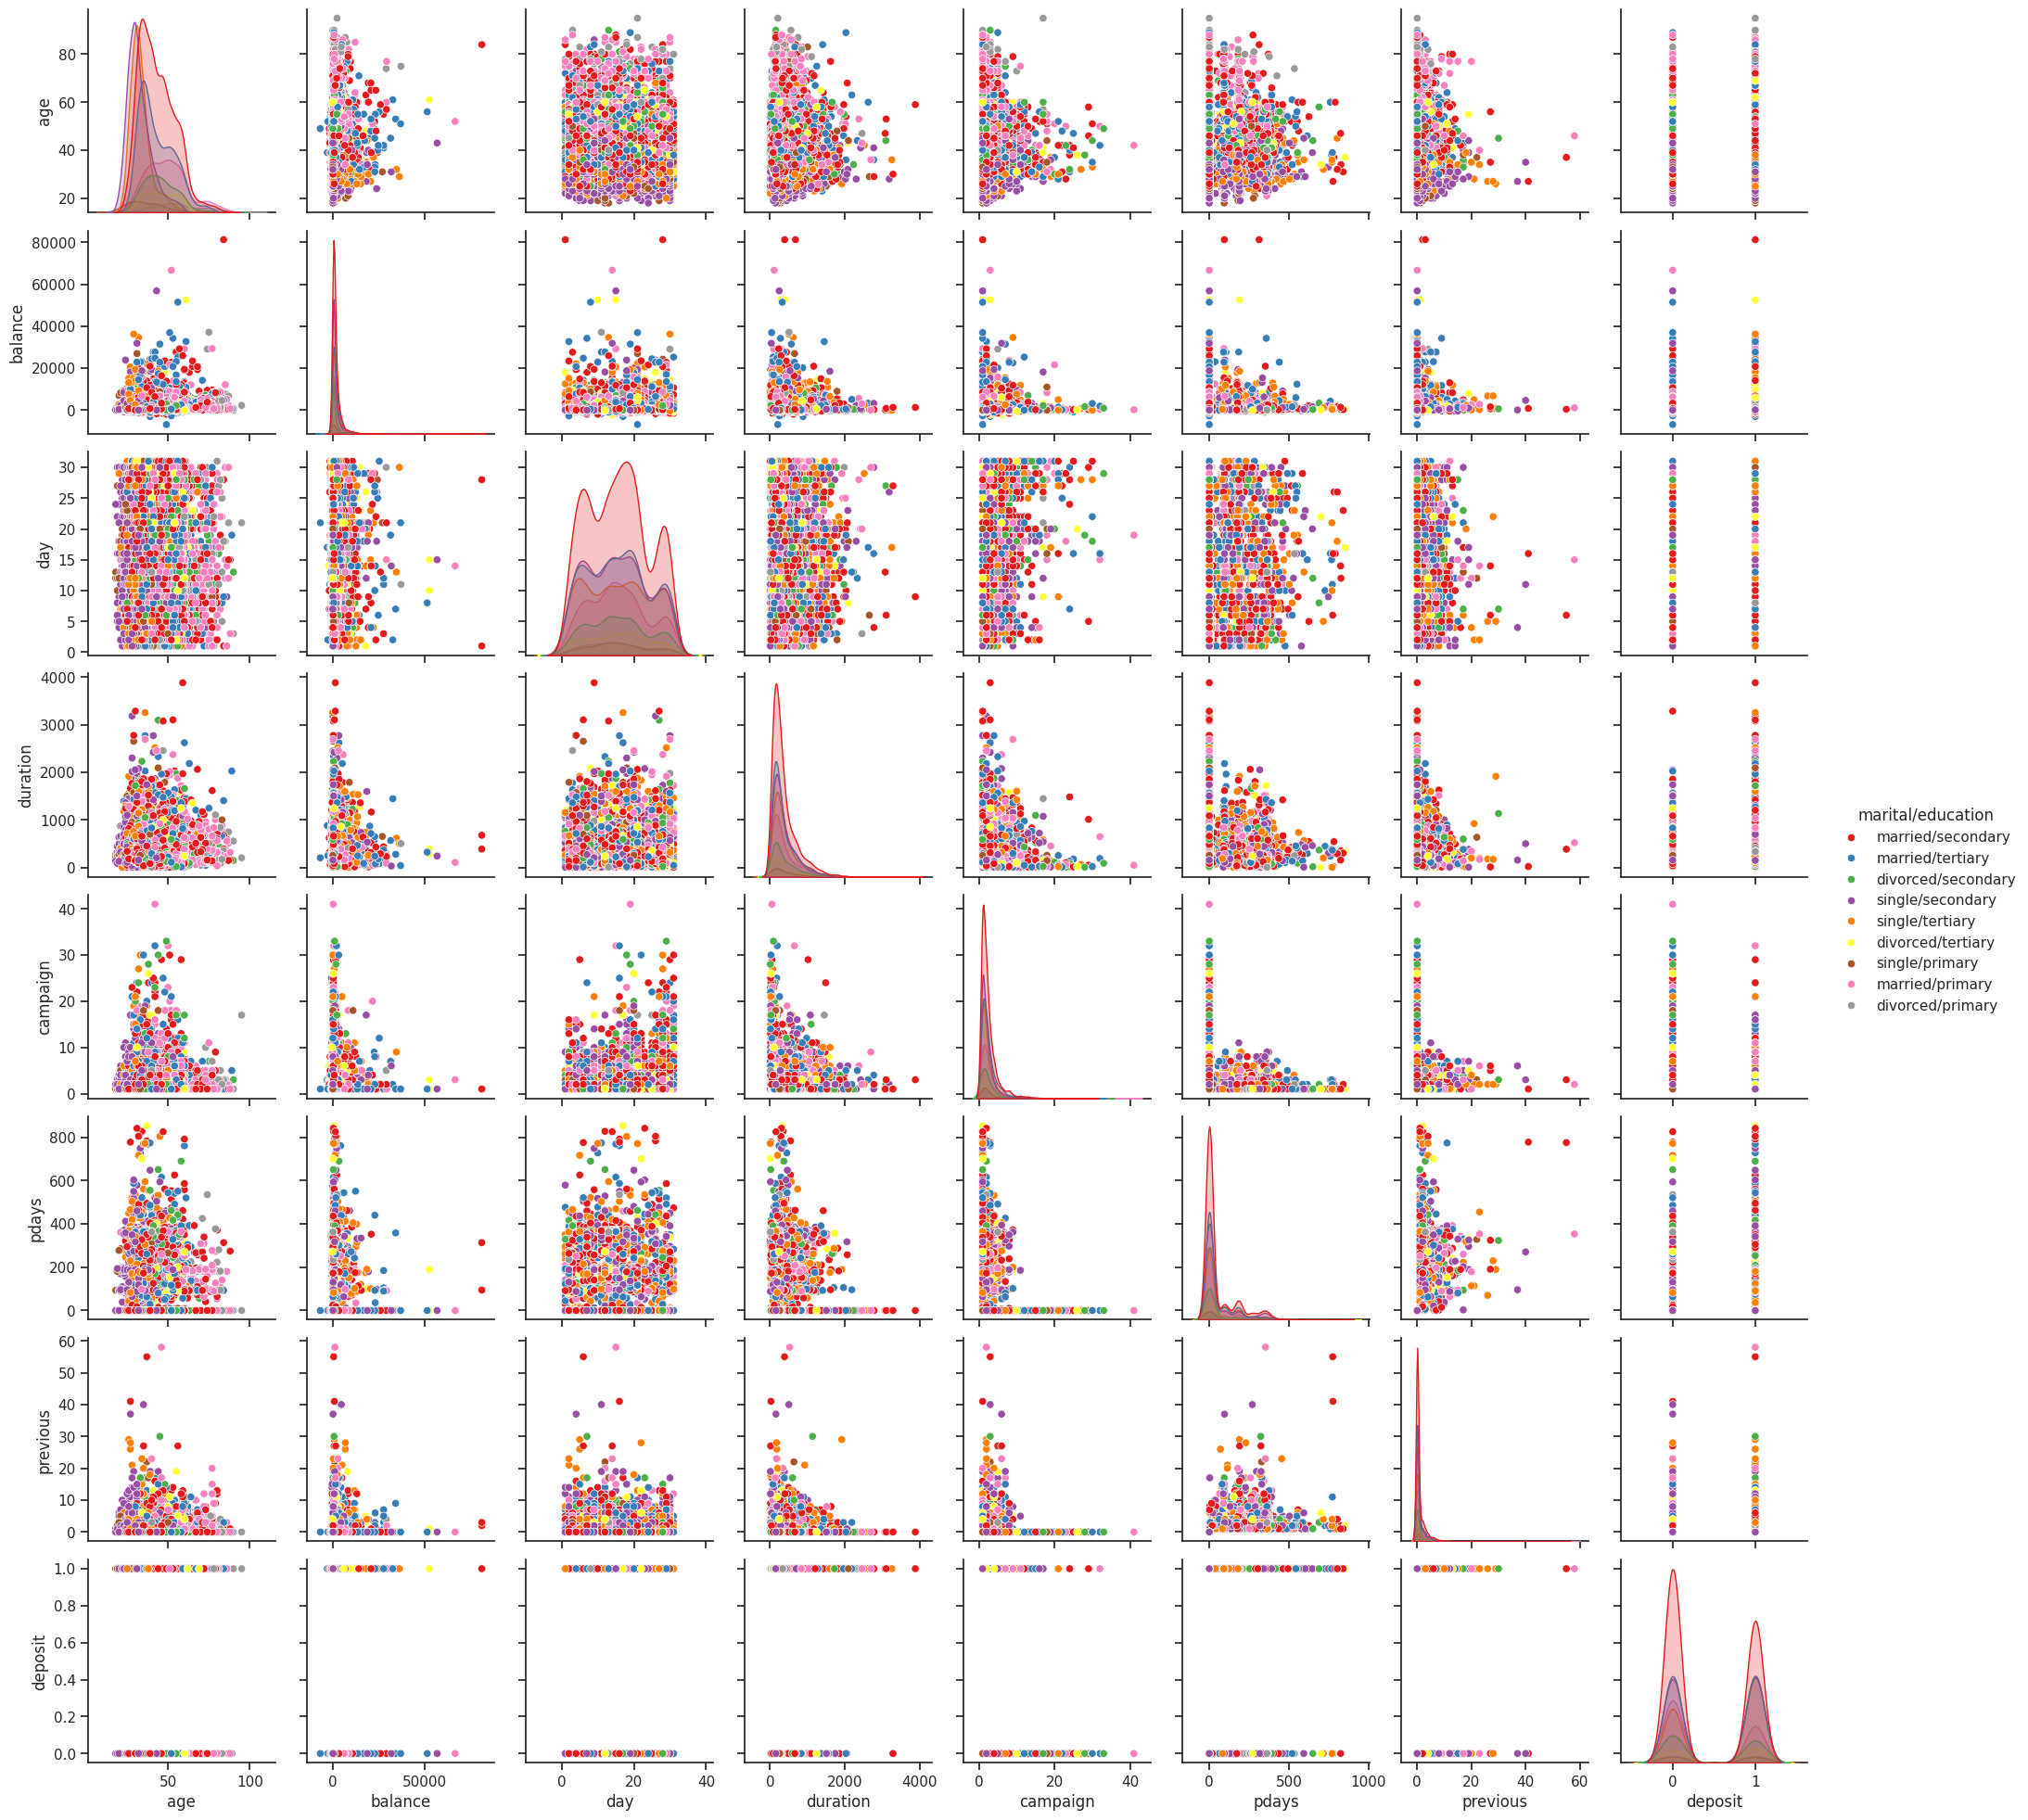

In [ ]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df, hue="marital/education", palette="Set1")
plt.show()

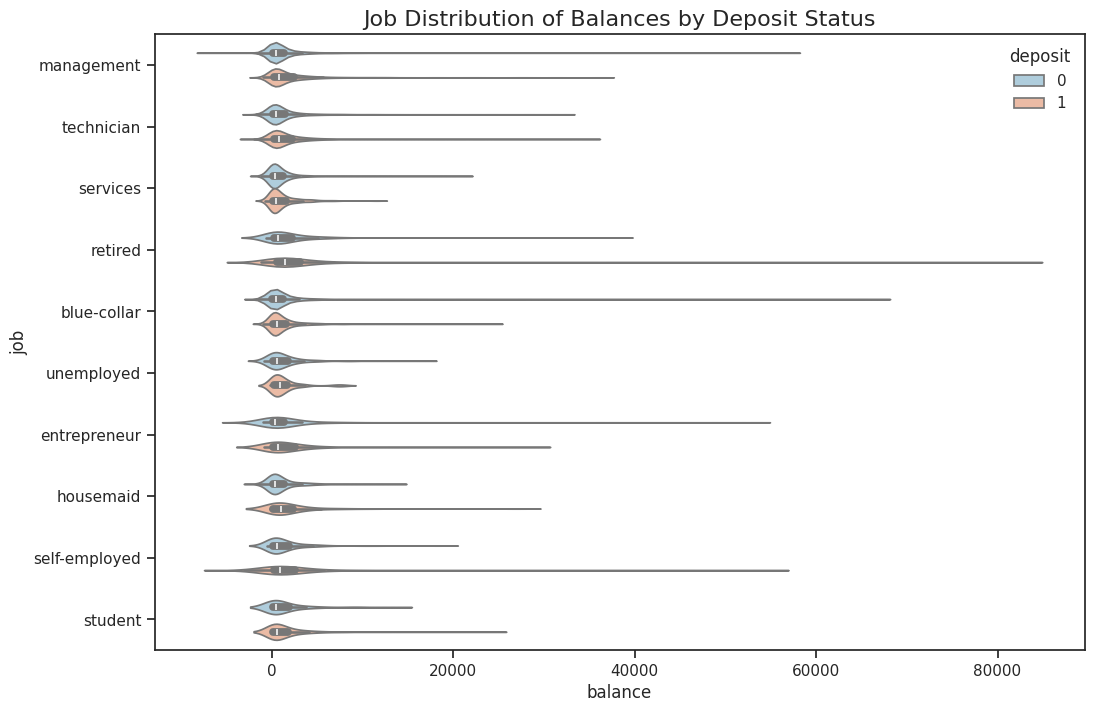

In [ ]:
fig = plt.figure(figsize=(12,8))

sns.violinplot(x="balance", y="job", hue="deposit", palette="RdBu_r",
            data=df);

plt.title("Job Distribution of Balances by Deposit Status", fontsize=16)

plt.show()

Marital Status: As discussed previously, a divorce has a significant impact on the balance of the individual.

Education: The education level also significantly impacts the amount of balance a prospect has.

Loans: Whether the prospect has a previous loan significantly impacts the amount of balance he or she has.

# Deposit

<Axes: title={'center': 'Deposit value counts'}, xlabel='deposit'>

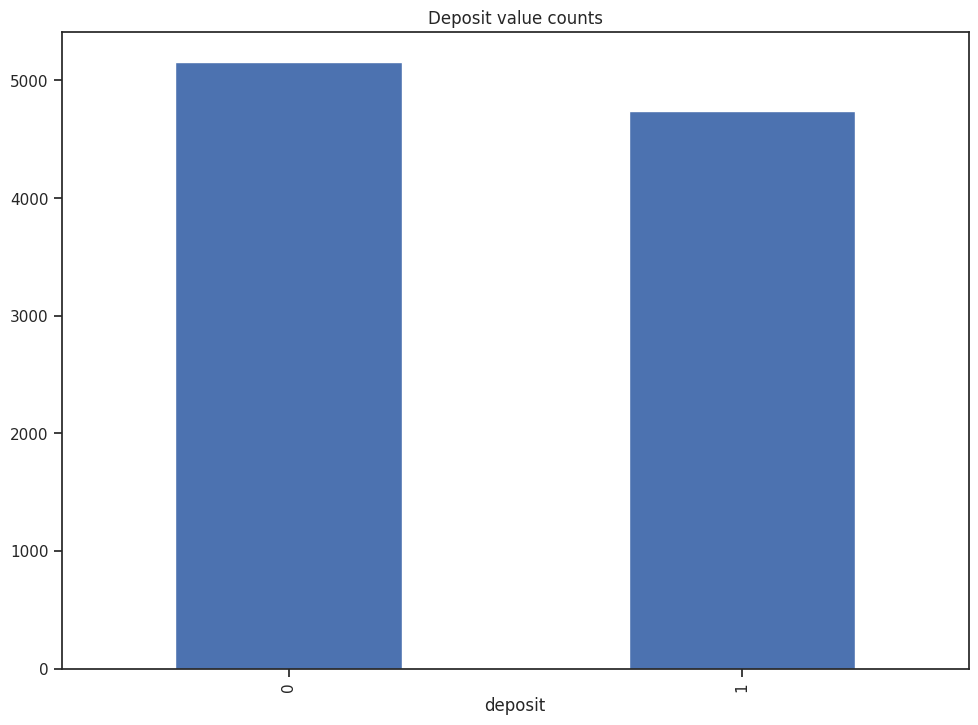

In [ ]:
value_counts = df['deposit'].value_counts()

value_counts.plot.bar(title = 'Deposit value counts')

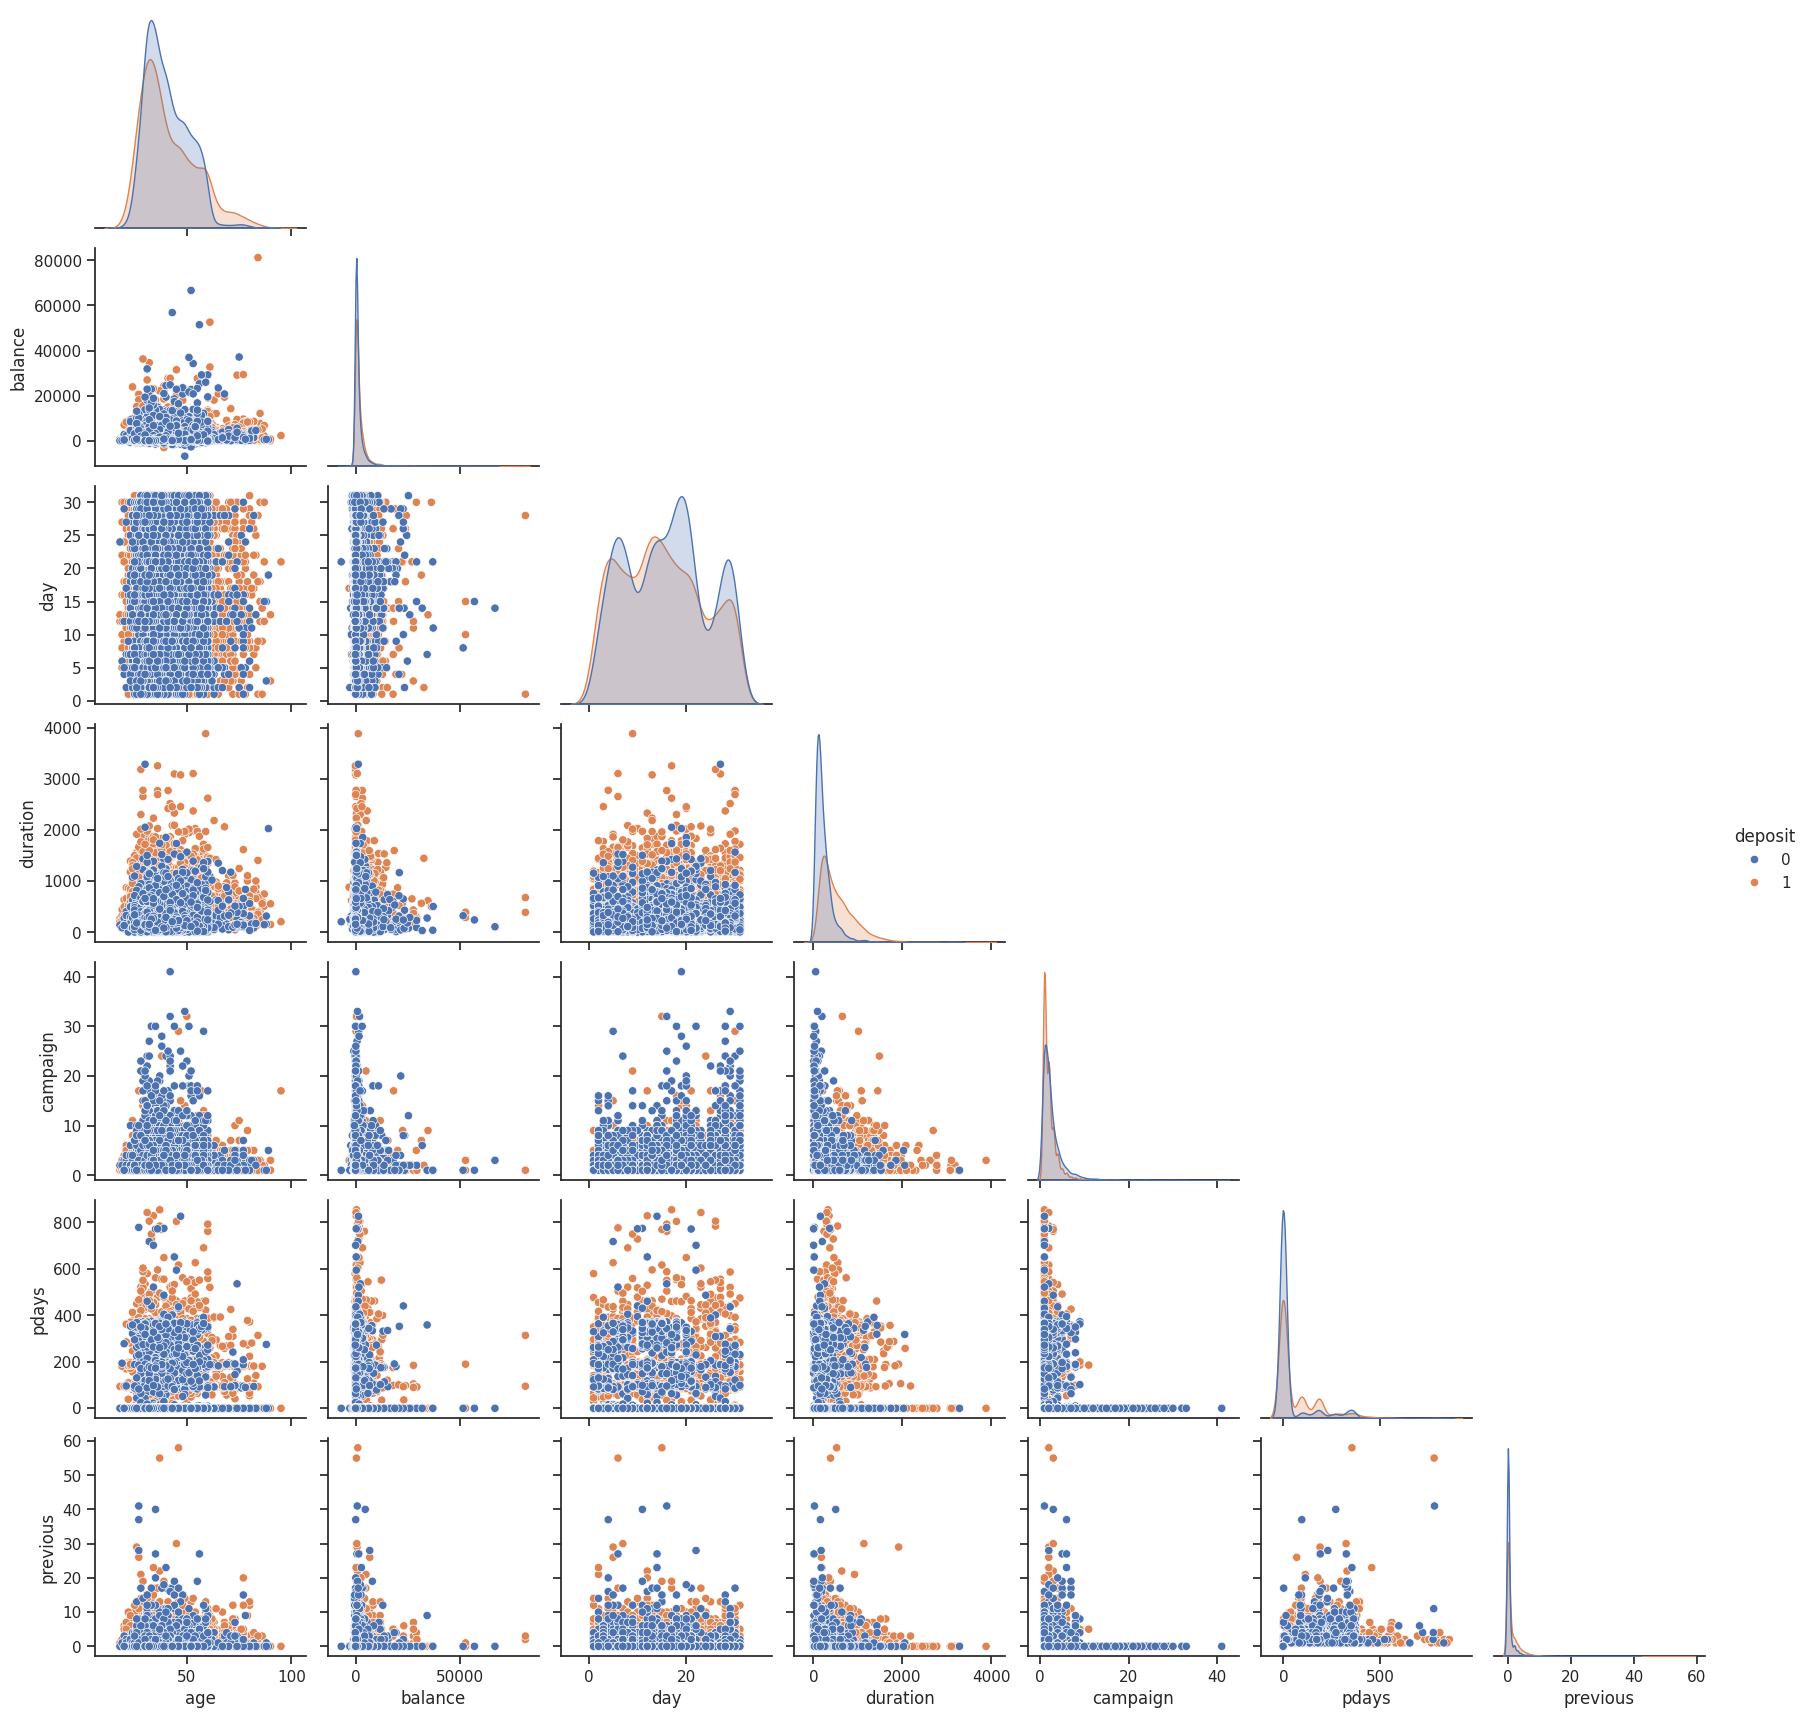

In [ ]:
sns.pairplot(df,hue='deposit',corner=True)

# Campaign Duration

In [ ]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59  management  married  secondary      no     2343     yes   no  unknown   
1   56  management  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54  management  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome  deposit  \
0    5   may      1042         1     -1         0  unknown        1   
1    5   may      1467         1     -1         0  unknown        1   
2    5   may      1389         1     -1         0  unknown        1   
3    5   may       579         1     -1         0  unknown        1   
4    5   may       673         2     -1         0  unknown        1   

   marital/education  
0  married/secondary  
1  married/secondary  
2  married/secondary  
3  married/secondary  
4   married/tertiary

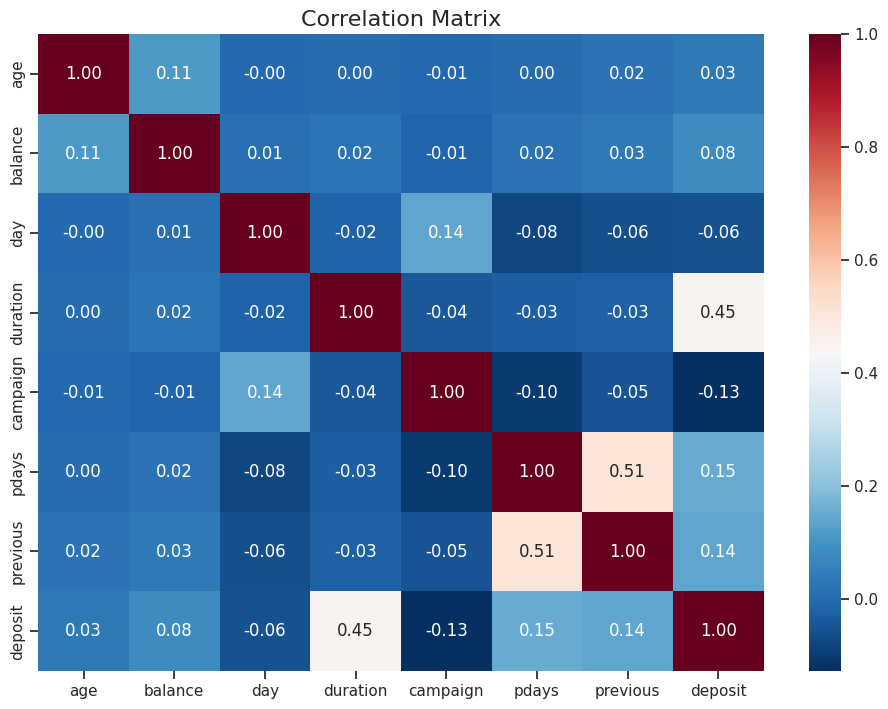

In [ ]:
# Calculate correlation matrix
corr_numeric = numeric_df.corr()

# Plot heatmap with correlation values annotated
sns.heatmap(corr_numeric, annot=True, fmt=".2f", cmap="RdBu_r", cbar=True)

plt.title("Correlation Matrix", fontsize=16)
plt.show()


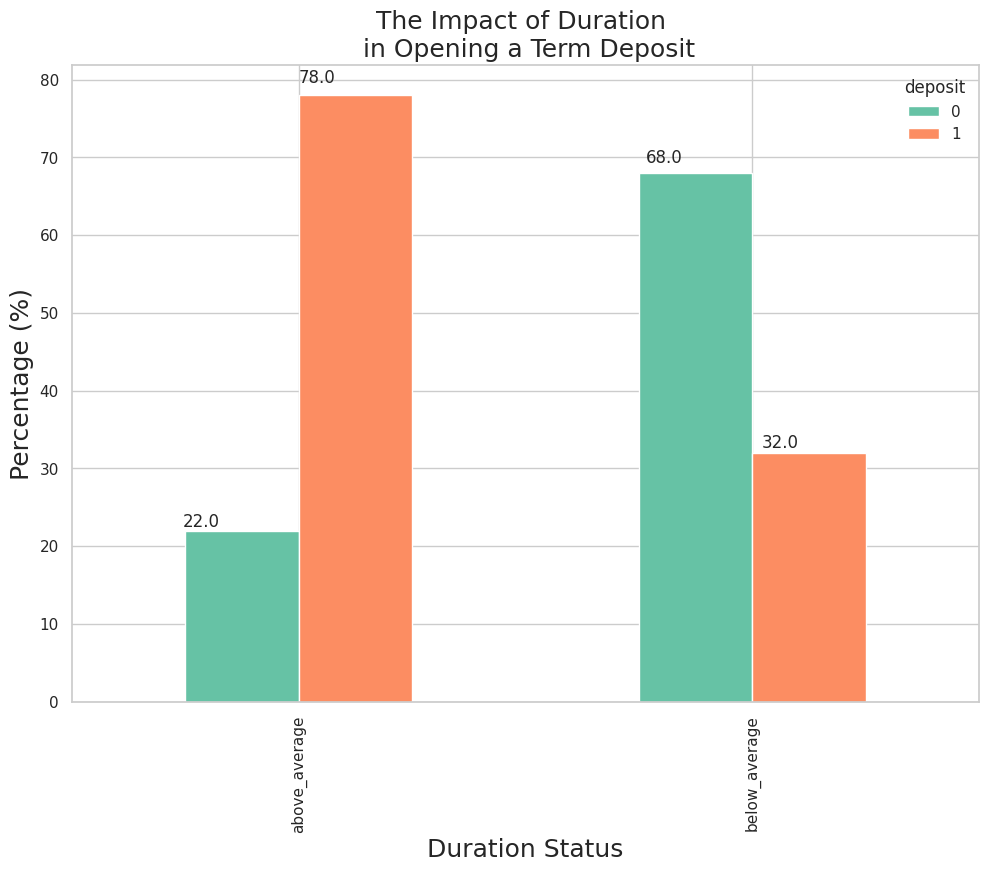

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
avg_duration = df['duration'].mean()

lst = [df]
df["duration_status"] = np.nan

for col in lst:
    col.loc[col["duration"] < avg_duration, "duration_status"] = "below_average"
    col.loc[col["duration"] > avg_duration, "duration_status"] = "above_average"

pct_term = pd.crosstab(df['duration_status'], df['deposit']).apply(lambda r: round(r/r.sum(), 2) * 100, axis=1)

sns.set_palette("Set2")

ax = pct_term.plot(kind='bar', stacked=False)
plt.title("The Impact of Duration \n in Opening a Term Deposit", fontsize=18)
plt.xlabel("Duration Status", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

plt.show()

Our analysis reveals a strong correlation between campaign duration and term deposit uptake. Longer campaign durations correspond to higher probabilities of clients opening term deposit accounts.

**Average Duration Overview:** The average campaign duration is 374.76 units, providing a benchmark for our analysis.

**Duration Status Impact**: Clients above the average duration exhibit a notable inclination towards opening term deposit accounts, with 78% engagement compared to 32% among those below average.

# **MODELS**

In [ ]:
# Time for Classification Models
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "MLP Classifier": MLPClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB()
}

In [ ]:
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.perf_counter()
        classifier.fit(X_train, Y_train)
        t_end = time.perf_counter()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [ ]:
df_results = batch_classify(X_train, y_train)
print(df_results.sort_values(by='train_score', ascending=False))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



trained Logistic Regression in 0.16 s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



trained MLP Classifier in 16.83 s
trained Gradient Boosting Classifier in 2.39 s
trained Decision Tree in 0.09 s
trained Naive Bayes in 0.01 s
                     classifier  train_score  training_time
3                 Decision Tree     1.000000       0.087097
1                MLP Classifier     0.930563      16.832142
2  Gradient Boosting Classifier     0.861463       2.385406
0           Logistic Regression     0.830776       0.161704
4                   Naive Bayes     0.721693       0.007610


# Avoiding Overfitting
The best alternative to avoid overfitting is to use cross validation. Taking the training test and splitting it

In [ ]:
# Use Cross-validation.
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'Dec Tree', 'Grad B CLF', 'Neural Classifier', 'Naives Bayes'],
    'Crossval Mean Scores': [log_reg_mean, tree_mean, grad_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

Classifiers  Crossval Mean Scores
3  Neural Classifier              0.849479
4       Naives Bayes              0.849479
2         Grad B CLF              0.844328
0      Logistic Reg.              0.828536
1           Dec Tree              0.786874

# Evaluation metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_predict

In [ ]:
accuracy = []
specificity = []
sensitivity = []
auc = []
f1 = []

# Calculate the metrics for each model
for clf_name, clf in dict_classifiers.items():

    y_pred = cross_val_predict(clf, X_train, y_train, cv=3)
    y_scores = cross_val_predict(clf, X_train, y_train, cv=3, method="predict_proba")

    accuracy.append(accuracy_score(y_train, y_pred))
    precision = precision_score(y_train, y_pred, pos_label=1)
    recall = recall_score(y_train, y_pred, pos_label=1)
    tn = np.sum((y_train == 0) & (y_pred == 0))
    fp = np.sum((y_train != 0) & (y_pred == 0))
    specificity.append(tn / (tn + fp))
    sensitivity.append(recall)
    auc.append(roc_auc_score(y_train, y_scores[:, 1]))
    f1.append(f1_score(y_train, y_pred, pos_label=1))

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    "Model": dict_classifiers.keys(),
    "Accuracy": accuracy,
    "Specificity": specificity,
    "Sensitivity": sensitivity,
    "AUC": auc,
    "F1 Score": f1
})

print(metrics_df)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

                          Model  Accuracy  Specificity  Sensitivity       AUC  \
0           Logistic Regression  0.828536     0.825319     0.799149  0.903453   
1                MLP Classifier  0.838616     0.852686     0.839319  0.907303   
2  Gradient Boosting Classifier  0.844327     0.864769     0.855151  0.917362   
3                 Decision Tree  0.784746     0.794398     0.771030  0.784859   
4                   Naive Bayes  0.720013     0.686979     0.565454  0.803352   

   F1 Score  
0  0.815431  
1  0.831363  
2  0.838897  
3  0.772491  
4  0.656876  


In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)

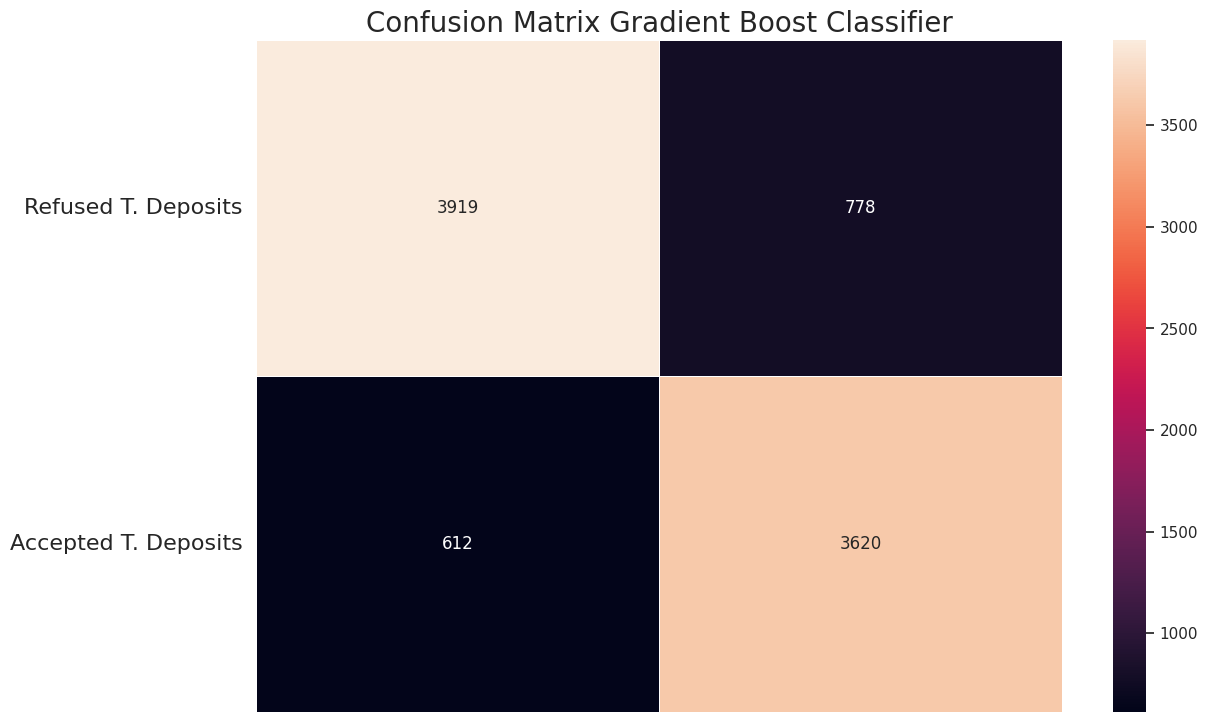

In [ ]:
from sklearn.metrics import confusion_matrix
# 4697: no's, 4232: yes
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix Gradient Boost Classifier", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()

# Precision and Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))

Precision Score:  0.8231014097316962
Recall Score:  0.8553875236294896


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.8389339513325608

In [ ]:
grad_clf.fit(X_train, y_train)
y_scores = grad_clf.decision_function([some_instance])
y_scores

array([-3.65645629])

In [ ]:
# Increasing the threshold decreases the recall.
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method="decision_function")
neural_y_scores = cross_val_predict(neural_clf, X_train, y_train, cv=3, method="predict_proba")
naives_y_scores = cross_val_predict(nav_clf, X_train, y_train, cv=3, method="predict_proba")

In [ ]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

if neural_y_scores.ndim == 2:
    neural_y_scores = neural_y_scores[:, 1]

if naives_y_scores.ndim == 2:
    naives_y_scores = naives_y_scores[:, 1]

In [ ]:
y_scores.shape

(8929,)

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

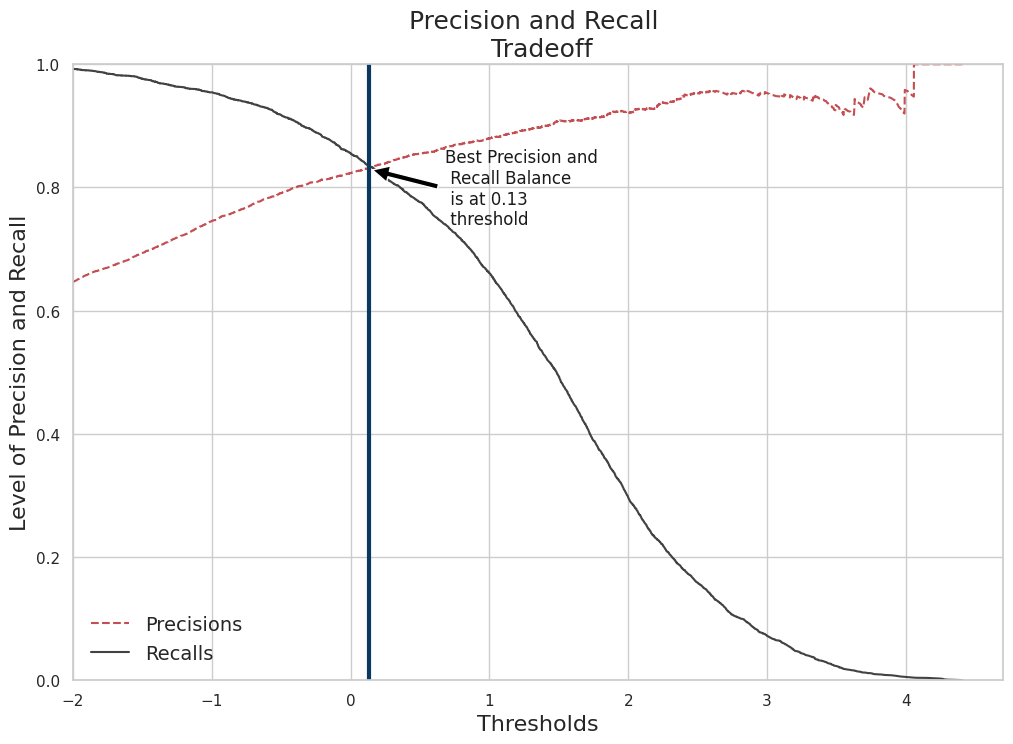

In [ ]:
def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Recalls")
    plt.title("Precision and Recall \n Tradeoff", fontsize=18)
    plt.ylabel("Level of Precision and Recall", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-2, 4.7])
    plt.ylim([0, 1])
    plt.axvline(x=0.13, linewidth=3, color="#0B3861")
    plt.annotate('Best Precision and \n Recall Balance \n is at 0.13 \n threshold ', xy=(0.13, 0.83), xytext=(55, -40),
             textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12,
                color='k')

precision_recall_curve(precisions, recalls, threshold)
plt.show()

As the precision gets higher, the recall gets lower and vice versa. For instance, if we increase the accuracy from 30% to 60%, the model picks the predictions that the model believes are 60% sure. If there is an instance where the model thinks it is 58% likely to be a potential client that will subscribe to a term deposit, then the model will classify it as a "No." However, that instance was a "Yes" (the potential client subscribed to a term deposit.) That is why the higher the precision, the more likely the model is to miss instances that actually say "Yes"!

# ROC Curve (Receiver Operating Characteristic)

In [ ]:
from sklearn.metrics import roc_curve
# Gradient Boosting Classifier
# Neural Classifier
# Naives Bayes Classifier
grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_scores)
neu_fpr, neu_tpr, neu_threshold = roc_curve(y_train, neural_y_scores)
nav_fpr, nav_tpr, nav_threshold = roc_curve(y_train, naives_y_scores)

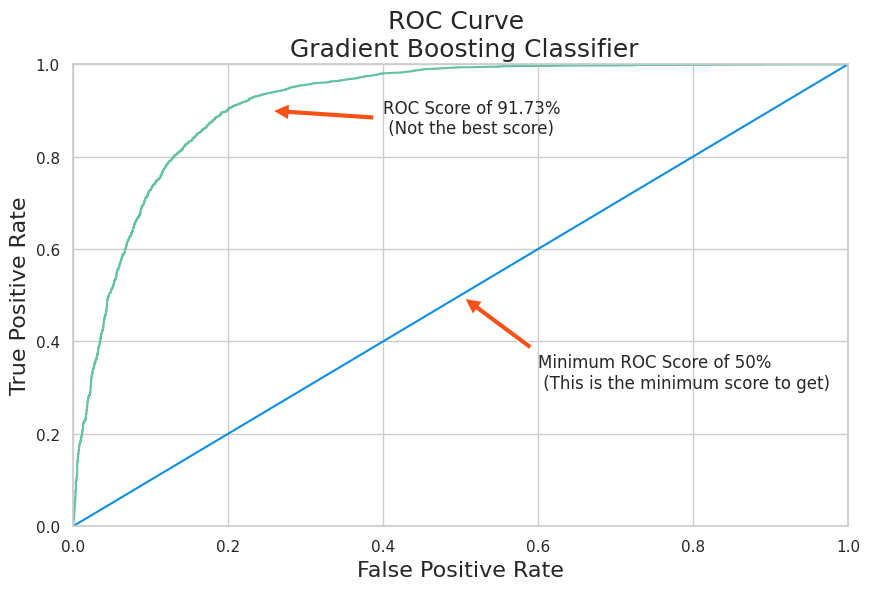

In [ ]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('ROC Curve \n Gradient Boosting Classifier', fontsize=18)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('ROC Score of 91.73% \n (Not the best score)', xy=(0.25, 0.9), xytext=(0.4, 0.85),
            arrowprops=dict(facecolor='#F75118', shrink=0.05),
            )
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )


graph_roc_curve(grd_fpr, grd_tpr, threshold)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print('Gradient Boost Classifier Score: ', roc_auc_score(y_train, y_scores))
print('Neural Classifier Score: ', roc_auc_score(y_train, neural_y_scores))
print('Naives Bayes Classifier: ', roc_auc_score(y_train, naives_y_scores))

Gradient Boost Classifier Score:  0.917404293775579
Neural Classifier Score:  0.9159901968557335
Naives Bayes Classifier:  0.803352414343226


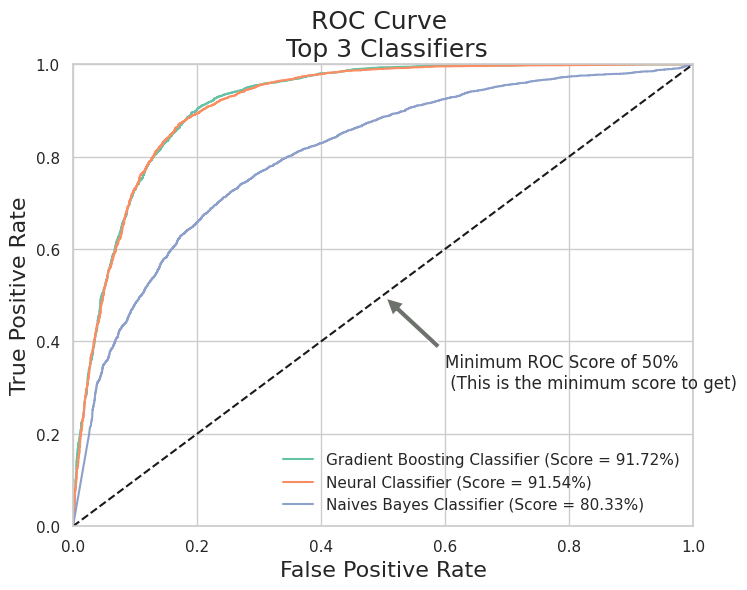

In [ ]:
def graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score = 91.72%)')
    plt.plot(neu_fpr, neu_tpr, label='Neural Classifier (Score = 91.54%)')
    plt.plot(nav_fpr, nav_tpr, label='Naives Bayes Classifier (Score = 80.33%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr)
plt.show()

The ROC curve shows how well our classifier classifies between term deposit subscriptions (True Positives) and non-term deposit subscriptions.
The X-axis is represented by False positive rates (Specificity), and the Y-axis is defined by the True Positive Rate (Sensitivity.) As the line moves, the threshold of the classification changes, giving us different values. The closer the line to our top left corner, the better our model separates both classes.

In [ ]:
grad_clf.predict_proba([some_instance])

array([[0.97482622, 0.02517378]])

In [ ]:
grad_clf.predict([some_instance])

array([0])

In [ ]:
y_train[1250]

0

# Features Influence the Result of a Term Deposit Subscription

<ipython-input-163-c8b629bbd7db>:6: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


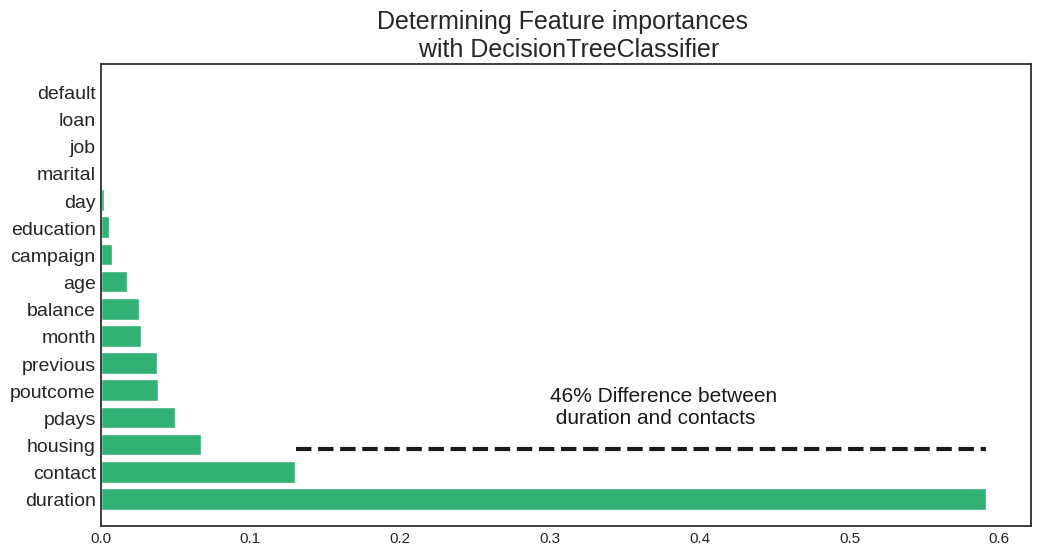

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes


target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01

)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)

feature_importance_graph(indices, importances, feature_names)
plt.show()

# The best model

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('gbc', grad_clf), ('nav', nav_clf), ('neural', neural_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc', GradientBoostingClassifier()),
                             ('nav', GaussianNB()),
                             ('neural', MLPClassifier(alpha=1))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (grad_clf, nav_clf, neural_clf, voting_clf):
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, predict))

GradientBoostingClassifier 0.8463949843260188
GaussianNB 0.7514554411106136
MLPClassifier 0.7456336766681594
VotingClassifier 0.8110165696372593


**Gradient Boosting classifier** is the best model to predict whether or not a potential client will suscribe to a term deposit or not. **84% accuracy**